**Loading the Libraries & Data**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sb
from IPython.display import clear_output

import torch 
import torch.nn as nn
import torch.utils.data as td


jena_df = pd.read_csv("jena_climate_2009_2016.csv")

jena_df = jena_df.rename(columns={"Date Time": "DateTime", "p (mbar)": "Pressure", "T (degC)": "TempCelsius", "Tpot (K)": "TempKelvin", "Tdew (degC)": "TempDewCelsius",
                        "rh (%)": "RelativeHumidity", "VPmax (mbar)": "SatVapourPress", "VPact (mbar)": "VapourPressure", "VPdef (mbar)": "VapPressDeficit",
                        "sh (g/kg)": "SpecificHumidity", "H2OC (mmol/mol)": "WaterVapConc", "rho (g/m**3)": "AirDensity", "wv (m/s)": "WindSpeed",
                        "max. wv (m/s)": "MaxWindSpeed", "wd (deg)": "WindDirDegrees"})

__Data Preprocessing__

All these steps are explained in the data cleaning sheet and combined here in one cell for fast processing of the data.

In [2]:
#taking only the hourly values
jena_df = jena_df[5::6]

#removing incorrect values
jena_df['WindSpeed'].replace(-9999, 0, inplace = True)
jena_df['MaxWindSpeed'].replace(-9999, 0, inplace = True)

#treating outliers
def out_treat(var):
    Q1 = np.quantile(var.dropna(), 0.25)
    Q3 = np.quantile(var.dropna(), 0.75)
    IQR = Q3-Q1
    LC = Q1 - (3 * IQR)
    UC = Q3 + (3 * IQR)
    var[var > UC] = UC
    var[var < LC] = LC
    return (var)
jena_df = jena_df[~jena_df.index.duplicated()]

jena_df.Pressure = out_treat(jena_df.Pressure)
jena_df.SatVapourPress = out_treat(jena_df.SatVapourPress)
jena_df.VapPressDeficit = out_treat(jena_df.VapPressDeficit)
jena_df.AirDensity = out_treat(jena_df.AirDensity)

#deriving the wind vector components
wv = jena_df.pop('WindSpeed')
max_wv = jena_df.pop('MaxWindSpeed')
# Convert to radians.
wd_rad = jena_df.pop('WindDirDegrees')*np.pi / 180
# Calculate the wind x and y components.
jena_df['Wx'] = wv*np.cos(wd_rad)
jena_df['Wy'] = wv*np.sin(wd_rad)
# Calculate the max wind x and y components.
jena_df['max Wx'] = max_wv*np.cos(wd_rad)
jena_df['max Wy'] = max_wv*np.sin(wd_rad)

#drop variables that have redundant data (multicollinearity)
jena_df.drop(['TempCelsius'],axis=1,inplace=True)
jena_df.drop(['VapourPressure'],axis=1,inplace=True)
jena_df.drop(['WaterVapConc'],axis=1,inplace=True)

#setting datetime as the index
jena_df.set_index('DateTime',inplace=True, drop=True)

#Seperating the independent and dependent data
data = jena_df
X = data.drop(columns=["TempKelvin"],axis=1)
y = data["TempKelvin"]

#Splitting the data for training and testing
x_train, x_test, y_train, y_test = train_test_split(X.values,y.values, test_size=0.2, shuffle=False)

#Scaling - Fit and Transform TRAIN data
min_max_scaler_x = MinMaxScaler()
x_train_sc = min_max_scaler_x.fit_transform(x_train)
x_test_sc = min_max_scaler_x.transform(x_test)

#Scaling - Fit and Transform TEST data
min_max_scaler_y = MinMaxScaler()    #we will use this scaler later to inverse transform predicted values
y_train_sc = min_max_scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_sc = min_max_scaler_y.transform(y_test.reshape(-1,1))

#Converting back to Pandas dataframe
x_train = pd.DataFrame(x_train_sc, columns = X.columns)
x_test = pd.DataFrame(x_test_sc, columns = X.columns)
y_train = pd.DataFrame(y_train_sc, columns = ["TempKelvin"])
y_test = pd.DataFrame(y_test_sc, columns = ["TempKelvin"])

#merging the two datasets for both training and testing data
last_col = y_train.pop("TempKelvin")
x_train.insert(x_train.shape[1], "TempKelvin", last_col)
last_col = y_test.pop("TempKelvin")
x_test.insert(x_test.shape[1], "TempKelvin", last_col)

#concatenating train and test data
data = x_train.append(x_test)

__Creating Sequences & Transforming to tensors__

Step by Step Explanation:

1] Creating sequences of 168 lags (1 week of historical data)taken for all the data.

2] Splitting the data into train and test section as decided before.

3] Slicing the numpy arrays from both train and test data to create sequences train_x, train_y, test_x and test_y. (Keeping the mind the offset decided: 24 - predicting 
temperature after 24 hours)

4] Transforming the numpy arrays into PyTorch tensors.

5] Joining input sequences tensors with output sequences tensors.

6] Defining batch size for train and test data and creating data loader files for both training and testing. 

In [3]:
def split_data(inputDF, lookback, offset):
    data_raw = inputDF.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size, :, :]
    y_train = data[lookback + offset:train_set_size+lookback+offset, 0, -1]
    
    x_test = data[train_set_size:- (offset+lookback), :, :]
    y_test = data[train_set_size + lookback + offset:, 0, -1]
    
    return [x_train, y_train, x_test, y_test]


lookback = 168 # choose sequence length
offset = 23
x_train, y_train, x_test, y_test = split_data(data, lookback, offset)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

y_train = y_train.view(len(y_train), 1)
y_test = y_test.view(len(y_test), 1)

train_tensor = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = np.math.ceil(len(x_train)/10), shuffle = False)

test_tensor = torch.utils.data.TensorDataset(x_test, y_test) 
test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = len(x_test),shuffle = False)

Checking if GPU available, then using it!

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("SELECTED DEVICE: ", device)
torch.cuda.empty_cache()
host = torch.device('cpu')
print("HOST DEVICE: ", host)

SELECTED DEVICE:  cuda
HOST DEVICE:  cpu


#LSTM
**Network Structure**

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

**Defining the Model**

LSTM neural network module in PyTorch can take 3D input tensors. And then the input to the LSTM module for times series is one at a time. We had to tune 'hidden_dim', 'num_layers' and 'num_epochs'. We also need one linear layer at the end to combine all the output from LSTM to one output value, given that we forecast one value for one input.

Hidden Dimensions are the number of units in hidden layer. We tried different values [32, 64, 128].  The computational effort is increasing by almost 40-50% with increase in layers. But as the dimensions were increased from 64 to 128 the validation loss is increasing. So we observed the better performance with 64 dimensions.

Number of layers: The performance of 2 LSTM layers was almost similar to using 1 LSTM layer. But the training time increases by 20-25%.

Number of Epochs: For every combination of hidden dimension and number of layers, we tried values of epochs from 20 to 70 with steps of 10. The model exhibited the best performance at 60.

In [6]:
input_dim = 12
hidden_dim = 32
output_dim = 1
num_layers = 1
num_epochs = 60

**Running Model over Epochs**

In [7]:
collect_MSE_sample = []

for i in range(30):
    clear_output(wait=True)
    print("Iteration: ", i+1)

    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers = num_layers, output_dim=output_dim)
    model.to(device)

    criterion = torch.nn.MSELoss(reduction='mean') #calculating the loss
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01) #adam optimiser with learning rate of 0.01

    #defining a function for test data
    def validation(model):
        with torch.no_grad():
            for input, target in test_loader:
                #input = input.view(input.size(0), input.size(1)) #chaning the shape from 3D to 2D   
                y_test_pred = model(input.to(device))
                test_loss = criterion(y_test_pred, target.to(device))
        return test_loss.item(), y_test_pred

    #training over the number of epochs
    import time #to measure the time taken by model to run
    training_losses = np.zeros(num_epochs)
    testing_losses = np.zeros(num_epochs)
    start_time = time.time()
    for t in range(num_epochs):
        for input, target in train_loader:
            #input = input.view(input.size(0), input.size(1)) #chaning the shape from 3D to 2D 
            y_train_pred = model(input.to(device)) #predicted values of train data
            train_loss = criterion(y_train_pred, target.to(device)) #calculate train loss

            optimiser.zero_grad() #making the gradients zero
            train_loss.backward() #backpropogating through the network by changing weights
            optimiser.step()
            
        training_losses[t] = train_loss.item()
        testing_losses[t] = validation(model)[0]

        print("Epoch ", t, "Train MSE: ", train_loss.item(), "Test MSE: ", validation(model)[0])

    collect_MSE_sample.append(testing_losses[num_epochs-1])   
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time), flush=True)

Iteration:  30
Epoch  0 Train MSE:  0.011191318742930889 Test MSE:  0.023456020280718803
Epoch  1 Train MSE:  0.012731416150927544 Test MSE:  0.007699037902057171
Epoch  2 Train MSE:  0.004503962583839893 Test MSE:  0.005032146815210581
Epoch  3 Train MSE:  0.003910156432539225 Test MSE:  0.004664397798478603
Epoch  4 Train MSE:  0.0038550703320652246 Test MSE:  0.004491815343499184
Epoch  5 Train MSE:  0.003633381798863411 Test MSE:  0.003980099689215422
Epoch  6 Train MSE:  0.0035379729233682156 Test MSE:  0.0037104713264852762
Epoch  7 Train MSE:  0.003484100569039583 Test MSE:  0.003617406589910388
Epoch  8 Train MSE:  0.003461710875853896 Test MSE:  0.00356334843672812
Epoch  9 Train MSE:  0.0034375437535345554 Test MSE:  0.003515671705827117
Epoch  10 Train MSE:  0.003433267818763852 Test MSE:  0.003507402492687106
Epoch  11 Train MSE:  0.0034522826317697763 Test MSE:  0.0035208628978580236
Epoch  12 Train MSE:  0.003480004845187068 Test MSE:  0.003530046669766307
Epoch  13 Train

In [13]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('#Points to Note:')
printmd(f"##1. Epochs Taken: {num_epochs}")
printmd(f"##2. Time Taken: {round(training_time)} seconds")
printmd(f"##3. testMSE_mean (30 samples): {round(np.mean(collect_MSE_sample), 6)}")
printmd(f"##3. testMSE_SD (30 samples): {round(np.std(collect_MSE_sample), 6)}")

#Points to Note:

##1. Epochs Taken: 60

##2. Time Taken: 87 seconds

##3. testMSE_mean (30 samples): 0.003237

##3. testMSE_SD (30 samples): 2.4e-05

**Transforming scaled data to original**

In [9]:
#predicted test data values
predict = pd.DataFrame(min_max_scaler_y.inverse_transform(validation(model)[1].to(host).detach().numpy()))
predict = predict.rename(columns={0: "Predicted"})
#original test data labels
original = pd.DataFrame(min_max_scaler_y.inverse_transform(y_test.detach().numpy()))
original = original.rename(columns={0: "Original"})

result = pd.concat([original, predict], axis=1, join='inner')
result.head(5)

,Original,Predicted
0,281.479980,282.668762
1,281.529999,282.736267
2,281.750000,284.132050
3,282.489990,285.026794
4,283.880005,284.373016


**Plotting training and testing losses**

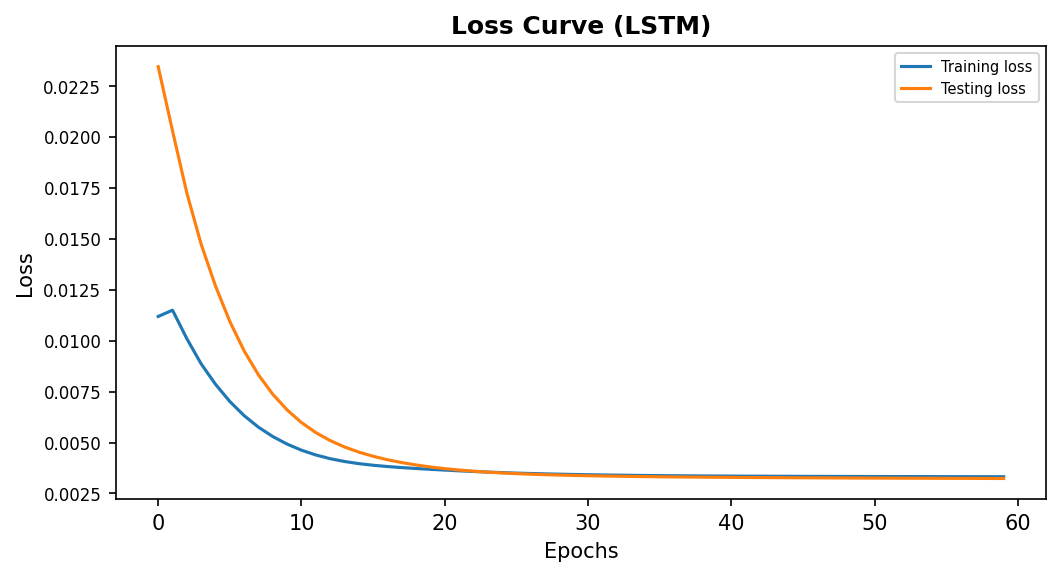

In [10]:
def smooth_curve(points, factor=0.8): #this function will make our plots more smooth
	smoothed_points = []
	for point in points:
		if smoothed_points:
			previous = smoothed_points[-1]
			smoothed_points.append(previous*factor+point*(1-factor))
		else:
			smoothed_points.append(point)
	return smoothed_points


# plotting the training and validation loss
plt.figure(figsize=(8,4),dpi=150)
plt.plot(smooth_curve(training_losses), label='Training loss')
plt.plot(smooth_curve(testing_losses), label='Testing loss')
plt.title('Loss Curve (LSTM)',fontweight='bold')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.yticks(size=8)
plt.legend(prop={'size': 7})
plt.show()

**Plotting predicted values against actual values**

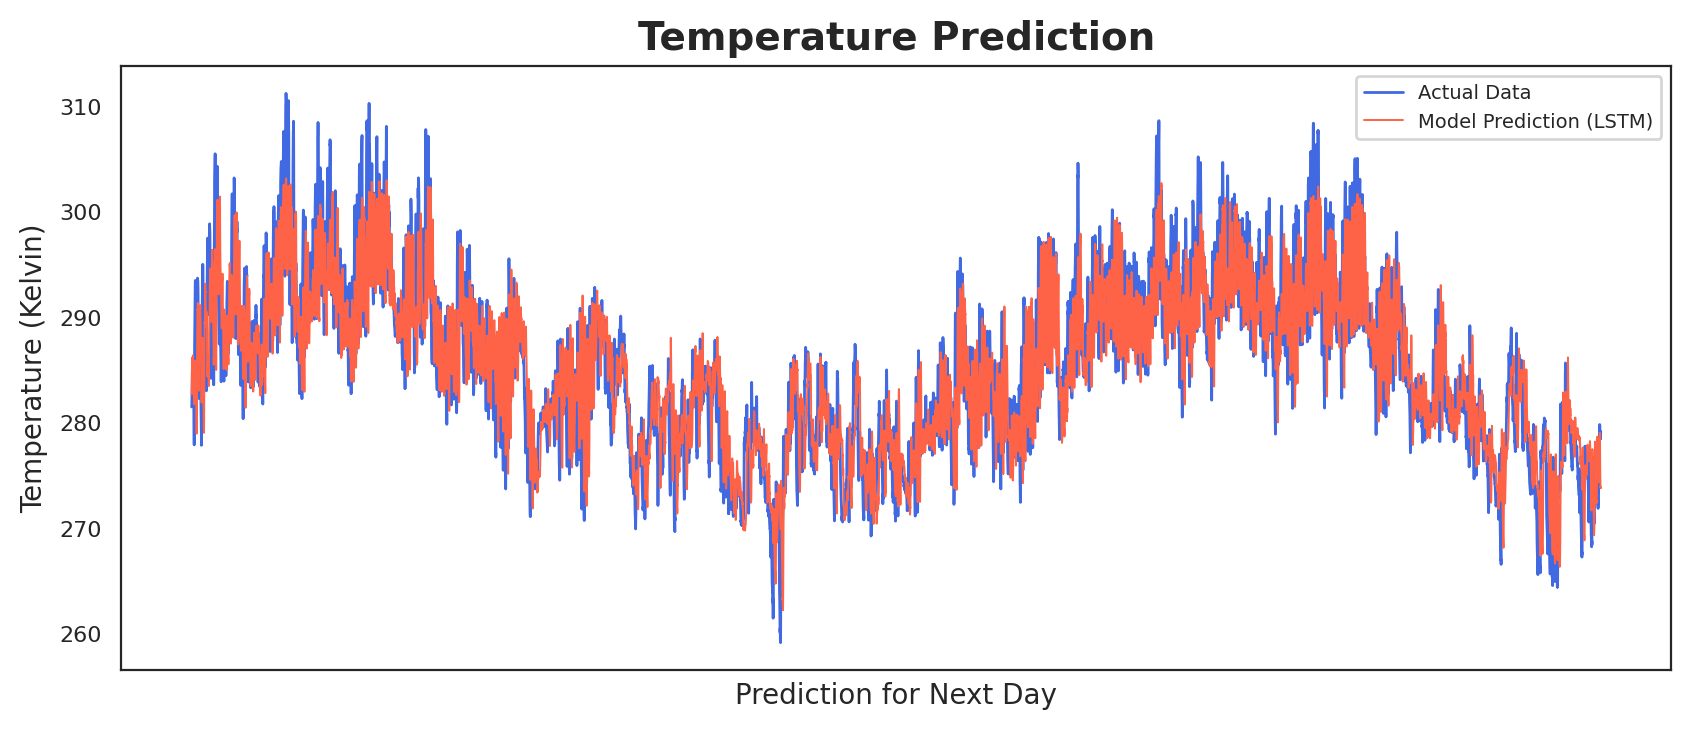

In [11]:
plt.figure(figsize = (10,4), dpi=200)
sb.set_style("white")    

sb.lineplot(x = result.index, y = result["Original"], label="Actual Data", color='royalblue',linewidth=1)
sb.lineplot(x = result.index, y = result["Predicted"], label="Model Prediction (LSTM)", color='tomato',linewidth=0.7)
plt.title('Temperature Prediction', size = 14, fontweight='bold')
plt.xlabel("Prediction for Next Day", size = 10)
plt.ylabel("Temperature (Kelvin)", size = 10)
plt.xticks(ticks=[])
plt.yticks(size=8)
plt.legend(loc="upper right", prop={'size': 7})
plt.show()